In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import os
import re
import scvi
import torch
import anndata
import pynndescent
import numba
import h5py
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.cm as cm
import scvelo as scv

[rank: 0] Global seed set to 0
/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scanpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.rcParams['figure.figsize']=(7,7)
torch.set_float32_matmul_precision('high')

In [4]:
h5_path='/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/HumanFetalBrainPool.h5'
ref_adata_path='/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/braun_2024_fetal_brain_filtered.h5ad'
hnoca_adata_path="/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/HNOCA/hnoca_pre-release_public_subset.h5ad"
adata_path="/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/BRO_RA1_exp023_annotated.h5ad"
ref_adata_neuron_path = "/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/braun_2024_fetal_brain_filtered_neuron_subset.h5ad"

In [5]:
adata = sc.read_h5ad(adata_path)

# Load Braun reference atlas

In [17]:
ref_adata = sc.read_h5ad(ref_adata_path)
#ref_adata_neurons = sc.read_h5ad(ref_adata_neuron_path)
ref_adata
#ref_adata_neurons

AnnData object with n_obs × n_vars = 1653974 × 33538
    obs: 'Age', 'CellClass', 'Region', 'Subdivision', 'Subregion', 'Tissue', 'TopLevelCluster', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'sample_id', 'cluster_id', 'region_class', 'subregion_class', 'n_genes'
    var: 'Chromosome', 'End', 'Gene', 'Start', 'Strand'
    uns: 'batch_condition', 'schema_version', 'title'
    layers: 'ambiguous', 'spliced', 'unspliced'

### Add neurotransmitter metadata

There is some hassle with the barcodes between the metadata and the adata

In [7]:
with h5py.File(h5_path, 'r') as f:
    clusters = f['shoji']['Clusters'][:]
    cells = f['shoji']['CellID'][:]

In [8]:
cells = cells.astype('str')
clusters = clusters.astype('int')

In [9]:
clusters_meta = pd.DataFrame(data={'clusters':clusters, 'cells':cells})
print(clusters_meta)

         clusters                      cells
0             240   10X89_1:AAACGGGAGGCTACGA
1             240   10X89_1:ACGAGGAAGAGCCTAG
2             236   10X89_1:ACGCCAGTCGATAGAA
3             240   10X89_1:CCGGGATCAGACACTT
4             233   10X89_1:CGACTTCTCCCACTTG
...           ...                        ...
1665932       255  10X302_7:AGAGAATAGAGGATCC
1665933       251  10X302_8:AAGCCATTCCACCTCA
1665934       251  10X302_8:ACGGTTAGTTAGGCCC
1665935       253  10X302_8:CATGCCTCAACCCGCA
1665936       251  10X302_8:CCTTTGGCAACGATTC

[1665937 rows x 2 columns]


In [10]:
barcodes = ref_adata.obs_names.tolist()

In [11]:
barcodes=[re.sub("^b\'", "",x) for x in barcodes]
barcodes=[re.sub("\'$", "",x) for x in barcodes]

In [12]:
barcodes

['10X89_1:ACGCCAGTCGATAGAA',
 '10X89_1:CTTCTCTAGTCAAGGC',
 '10X89_1:GGGCACTAGCGATATA',
 '10X89_1:TTCTACAAGGTGTGGT',
 '10X89_2:AACACGTAGACTGTAA',
 '10X89_2:CGTTAGAGTGCACTTA',
 '10X89_2:GTGCGGTGTTTGTTGG',
 '10X89_3:ATCCGAACAAGCTGTT',
 '10X89_3:CAAGAAACATGGAATA',
 '10X89_3:GATGCTATCTGCCAGG',
 '10X89_4:TTCCCAGGTATTACCG',
 '10X89_6:ACAGCCGGTGCAACGA',
 '10X89_6:CCTACACAGTGGAGTC',
 '10X89_7:ACCTTTAGTCACCTAA',
 '10X89_7:ACGCCGATCTTGGGTA',
 '10X89_7:ACTGAGTGTCTAAAGA',
 '10X89_7:AGAATAGCAATAACGA',
 '10X89_7:AGCGTATGTTGATTCG',
 '10X89_7:CAACCAATCAACACTG',
 '10X89_7:CAACTAGTCACGCGGT',
 '10X89_7:CAAGATCAGATCCCAT',
 '10X89_7:CACAGTATCATGTAGC',
 '10X89_7:CAGCCGAAGTTACGGG',
 '10X89_7:CCACGGATCAACTCTT',
 '10X89_7:CCATGTCCACTGCCAG',
 '10X89_7:CCTACACCAGGTTTCA',
 '10X89_7:CGAGCCAAGTCGTACT',
 '10X89_7:CGTCCATTCTGGGCCA',
 '10X89_7:GACGGCTAGTAAGTAC',
 '10X89_7:GCAATCAGTTGGACCC',
 '10X89_7:GGAAAGCCACTCTGTC',
 '10X89_7:GGCGTGTAGAGTGAGA',
 '10X89_7:GTTAAGCAGTGCGTGA',
 '10X89_7:TAAACCGTCCATTCTA',
 '10X89_7:TAAA

In [13]:
ref_adata.obs_names = barcodes

In [14]:
ref_adata

AnnData object with n_obs × n_vars = 1653974 × 33538
    obs: 'Age', 'CellClass', 'Region', 'Subdivision', 'Subregion', 'Tissue', 'TopLevelCluster', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'sample_id', 'cluster_id', 'region_class', 'subregion_class', 'n_genes'
    var: 'Chromosome', 'End', 'Gene', 'Start', 'Strand'
    uns: 'batch_condition', 'schema_version', 'title'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [15]:
clusters_meta['cells'].isin(ref_adata.obs_names)

0          False
1          False
2           True
3          False
4          False
           ...  
1665932     True
1665933     True
1665934     True
1665935     True
1665936     True
Name: cells, Length: 1665937, dtype: bool

In [16]:
clusters_meta = clusters_meta[clusters_meta['cells'].isin(ref_adata.obs_names)]
clusters_meta

clusters                      cells
2             236   10X89_1:ACGCCAGTCGATAGAA
5             235   10X89_1:CTTCTCTAGTCAAGGC
7             234   10X89_1:GGGCACTAGCGATATA
9             234   10X89_1:TTCTACAAGGTGTGGT
13            236   10X89_2:AACACGTAGACTGTAA
...           ...                        ...
1665932       255  10X302_7:AGAGAATAGAGGATCC
1665933       251  10X302_8:AAGCCATTCCACCTCA
1665934       251  10X302_8:ACGGTTAGTTAGGCCC
1665935       253  10X302_8:CATGCCTCAACCCGCA
1665936       251  10X302_8:CCTTTGGCAACGATTC

[1653974 rows x 2 columns]

In [17]:
clusters_meta['cells']==ref_adata.obs_names

2          True
5          True
7          True
9          True
13         True
           ... 
1665932    True
1665933    True
1665934    True
1665935    True
1665936    True
Length: 1653974, dtype: bool

In [18]:
clusters_meta.index = clusters_meta['cells']
clusters_meta

clusters                      cells
cells                                                         
10X89_1:ACGCCAGTCGATAGAA        236   10X89_1:ACGCCAGTCGATAGAA
10X89_1:CTTCTCTAGTCAAGGC        235   10X89_1:CTTCTCTAGTCAAGGC
10X89_1:GGGCACTAGCGATATA        234   10X89_1:GGGCACTAGCGATATA
10X89_1:TTCTACAAGGTGTGGT        234   10X89_1:TTCTACAAGGTGTGGT
10X89_2:AACACGTAGACTGTAA        236   10X89_2:AACACGTAGACTGTAA
...                             ...                        ...
10X302_7:AGAGAATAGAGGATCC       255  10X302_7:AGAGAATAGAGGATCC
10X302_8:AAGCCATTCCACCTCA       251  10X302_8:AAGCCATTCCACCTCA
10X302_8:ACGGTTAGTTAGGCCC       251  10X302_8:ACGGTTAGTTAGGCCC
10X302_8:CATGCCTCAACCCGCA       253  10X302_8:CATGCCTCAACCCGCA
10X302_8:CCTTTGGCAACGATTC       251  10X302_8:CCTTTGGCAACGATTC

[1653974 rows x 2 columns]

In [19]:
ref_adata.obs['Clusters'] = clusters_meta['clusters']

In [20]:
ref_adata.obs['Clusters']

10X89_1:ACGCCAGTCGATAGAA     236
10X89_1:CTTCTCTAGTCAAGGC     235
10X89_1:GGGCACTAGCGATATA     234
10X89_1:TTCTACAAGGTGTGGT     234
10X89_2:AACACGTAGACTGTAA     236
                            ... 
10X302_7:AGAGAATAGAGGATCC    255
10X302_8:AAGCCATTCCACCTCA    251
10X302_8:ACGGTTAGTTAGGCCC    251
10X302_8:CATGCCTCAACCCGCA    253
10X302_8:CCTTTGGCAACGATTC    251
Name: Clusters, Length: 1653974, dtype: int64

### Add NTT to Braun metadata

In [21]:
table_s2 = pd.read_excel("/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/table_S2.xlsx", sheet_name="Sheet1")
table_s2

PoolOrder PoolCleanOrder  TopLevelOrder  TopLevelCluster  SubCluster  \
0            0            575            276               14          15   
1            1             --            347               17           8   
2            2             --            346               17           7   
3            3             --            345               17           6   
4            4             --            344               17           5   
..         ...            ...            ...              ...         ...   
698        698            245            483               26          14   
699        699             --            476               26           7   
700        700            241            478               26           9   
701        701             --            479               26          10   
702        702            242            477               26           8   

     NCells   AutoClass   Class Subclass  Cycling  ... MeanCellCycleScore  \
0      2387      Neuron  Neuron   Neuron    False  ...           0.001869   
1       102  Neuroblast  Failed   Failed    False  ...           0.001790   
2       100  Neuroblast  Failed   Failed    False  ...           0.001800   
3        54  Neuroblast  Failed   Failed    False  ...           0.003312   
4       107  Neuroblast  Failed   Failed    False  ...           0.002544   
..      ...         ...     ...      ...      ...  ...                ...   
698     432      Immune  Immune   Immune     True  ...           0.014385   
699      33      Immune  Failed   Failed    False  ...           0.003257   
700     540      Immune  Immune   Immune    False  ...           0.003289   
701      41  Fibroblast  Failed   Failed    False  ...           0.003847   
702     643      Immune  Immune   Immune    False  ...           0.003396   

    MeanDoubletScore                                   TopLevelEnriched  \
0           0.163664  TFAP2D,LHX9,C1QL4,POU4F1,MAB21L1,OBI1-AS1,EBF2...   
1           0.215119  HRK,ACTC1,GNG8,NWD2,CPNE9,SHOX2,AL137139.2,COL...   
2           0.202511  HRK,ACTC1,GNG8,NWD2,CPNE9,SHOX2,AL137139.2,COL...   
3           0.232875  HRK,ACTC1,GNG8,NWD2,CPNE9,SHOX2,AL137139.2,COL...   
4           0.173229  HRK,ACTC1,GNG8,NWD2,CPNE9,SHOX2,AL137139.2,COL...   
..               ...                                                ...   
698         0.166793  SPP1,C1QC,AIF1,TYROBP,C1QB,CCL3,C1QA,P2RY12,CC...   
699         0.112663  SPP1,C1QC,AIF1,TYROBP,C1QB,CCL3,C1QA,P2RY12,CC...   
700         0.141962  SPP1,C1QC,AIF1,TYROBP,C1QB,CCL3,C1QA,P2RY12,CC...   
701         0.099029  SPP1,C1QC,AIF1,TYROBP,C1QB,CCL3,C1QA,P2RY12,CC...   
702         0.100018  SPP1,C1QC,AIF1,TYROBP,C1QB,CCL3,C1QA,P2RY12,CC...   

                                        SubsetEnriched  \
0    NRP2,NWD2,GNG8,MMRN1,CPNE4,CDH8,AC093866.1,CRH...   
1    SNCG,NWD2,GPC3,OBI1-AS1,CHRNB3,ONECUT1,PCOLCE2...   
2    GRIP2,SUSD4,AC135782.1,LINC00290,ADAM11,AC0041...   
3    DLX2,DLX6-AS1,FOXG1-AS1,LINC01551,GAD2,FOXG1,D...   
4    LINC02759,AC021723.2,LINC01482,CRAT37,TMEM235,...   
..                                                 ...   
698  RRM2,SPC25,KIF18B,AURKB,NDC80,MELK,MKI67,ANLN,...   
699  MT1G,HBE1,MT1H,MT2A,MT1X,TNFSF15,MT1F,SLC13A1,...   
700  F13A1,SELENOP,COLEC12,SIGLEC1,LILRB5,TIMD4,CD2...   
701  LUM,COL3A1,TAGLN,COL1A1,DCN,COL1A2,IGF2,COL6A2...   
702  DEFA1,MPO,S100A12,FCN1,LYZ,HLA-DRB5,HLA-DRB1,H...   

                                          PoolEnriched  \
0    GNG8,NWD2,CPNE9,POU4F1,OBI1-AS1,SNCG,AC093866....   
1    NWD2,GNG8,CPNE9,CPNE4,POU4F1,OBI1-AS1,CHRNB3,H...   
2    CPNE9,CPNE4,NWD2,HRK,CNTN2,GNG8,AL137139.2,COL...   
3    GNG8,CPNE9,HRK,CNTN2,AC105450.1,AC093503.2,MDG...   
4    ACTC1,HRK,GNG8,CNTN2,TESC,TPPP3,SHOX2,MDGA1,AL...   
..                                                 ...   
698  CX3CR1,C3,AIF1,C1QC,C1QB,P2RY12,SAMSN1,APBB1IP...   
699  C1QC,HMOX1,C1QB,TYROBP,AIF1,TREM2,SPP1,C1QA,VS...   
700  LYVE1,RNASE1,F13A1,MRC1,CD14,M

In [22]:
table_s2[table_s2["Class"] == "Neuron"]["AutoAnnotation"].str.count("NT-").value_counts(sort=True)

AutoAnnotation
1    194
2     13
0     10
3      1
Name: count, dtype: int64

In [23]:
l = [i.split(" | ") for i in table_s2[table_s2["Class"].isin(["Neuron", "Neuroblast"])]["AutoAnnotation"]]
sorted(set([i for j in l for i in j]))

['GBL',
 'HB-OTV',
 'M-ERY',
 'NBL',
 'NEUR',
 'NP-GNRH',
 'NP-HCRT',
 'NP-POMC',
 'NP-TRH',
 'NT-CHOL',
 'NT-GABA',
 'NT-GLY',
 'NT-SER',
 'NT-VGLUT1',
 'NT-VGLUT2',
 'NT-VGLUT3',
 'O-HEM',
 'OPC',
 'P-DLGE',
 'P-FP1',
 'P-PALL',
 'P-PALL-M',
 'P-SUBPALL',
 'P-TEL',
 'P-VLGE',
 'PREOPC',
 'RGL',
 'S-CC',
 'S-G1S',
 'S-G2M',
 'TH-RETN']

In [24]:
ts = table_s2.set_index("PoolCleanOrder").to_dict()["AutoAnnotation"]
ts

{575: 'NEUR | NT-VGLUT2',
 '--': 'RGL | M-IMMUNE | M-MGL | M-PVM | M-FBL | S-CC',
 68: 'NBL | RGL | S-CC | S-G1S',
 69: 'NBL | S-CC | S-G1S',
 70: 'NBL | NEUR | S-CC | S-G2M',
 71: 'NBL | NEUR | S-CC | S-G1S',
 578: 'NBL | NEUR | NT-VGLUT2',
 577: 'NBL | NEUR | NP-TRH | NT-VGLUT2',
 576: 'NBL | NEUR | NT-VGLUT2',
 587: 'NEUR | NT-VGLUT2',
 584: 'NEUR | NT-VGLUT2',
 585: 'NEUR | NT-VGLUT2',
 586: 'NEUR | NP-TRH | NT-VGLUT2',
 582: 'NEUR | NT-VGLUT2',
 583: 'NEUR | NP-TRH | NT-VGLUT2',
 581: 'NEUR | NT-VGLUT2',
 580: 'NEUR | NT-VGLUT2',
 579: 'NEUR | NT-VGLUT2',
 565: 'NEUR | NT-VGLUT2',
 563: 'NEUR | NT-VGLUT2',
 564: 'NEUR | NT-VGLUT2',
 562: 'NEUR | NT-VGLUT2',
 561: 'NEUR | NT-VGLUT2',
 560: 'NEUR | NT-VGLUT2',
 559: 'NEUR | NT-VGLUT2',
 558: 'NEUR | NT-VGLUT2',
 574: 'NBL | NEUR | NT-VGLUT2',
 573: 'NBL | NEUR | NT-VGLUT2',
 572: 'NBL | NEUR | NT-VGLUT2',
 571: 'NBL | NEUR | NT-VGLUT2',
 570: 'NBL | NEUR | NP-HCRT | NT-VGLUT2',
 588: 'HB-OTV | NBL | NEUR | NT-VGLUT1 | NT-VGLUT2',
 5

In [25]:
neurotransmitters = ['NT-CHOL', 'NT-GABA', 'NT-GLY', 'NT-SER', 'NT-VGLUT1', 'NT-VGLUT2', 'NT-VGLUT3']

for nt in neurotransmitters:
    ref_adata.obs[nt] = [nt in ts[i] for i in ref_adata.obs["Clusters"]]

ref_adata.obs['NTT'] = ref_adata.obs.apply(
    lambda row: ', '.join(nt for nt in neurotransmitters if row[nt]),
    axis=1
)

In [26]:
ref_adata.obs[neurotransmitters].sum(axis=1).value_counts()

0    802549
1    741093
2    104232
3      6100
Name: count, dtype: int64

In [27]:
ref_adata.obs['NTT'].value_counts()

NTT
                                 802549
NT-GABA                          373907
NT-VGLUT2                        245602
NT-VGLUT1, NT-VGLUT2              86699
NT-VGLUT1                         59171
NT-GLY                            46568
NT-VGLUT3                          9345
NT-GABA, NT-VGLUT2                 6710
NT-GABA, NT-VGLUT1, NT-VGLUT2      6100
NT-GLY, NT-VGLUT2                  4929
NT-GABA, NT-VGLUT3                 3872
NT-CHOL                            3516
NT-SER                             2984
NT-SER, NT-VGLUT3                  2022
Name: count, dtype: int64

Now we've added the neurotransmitter type to our reference data. Apparently there are some neurons that are responsive to multiple NTs. We'll see where they are and keep an eye on them as they might potentially be interferring with our referencing. 

In [18]:
harm_ref_adata = ref_adata[:,np.intersect1d(ref_adata.var_names, adata.var_names)].copy()

In [19]:
ref_adata_neurons = harm_ref_adata[harm_ref_adata.obs['CellClass'].isin(["b'Neuron'","b'Neuroblast'","b'Neuronal IPC'"])].copy()
ref_adata_neurons

AnnData object with n_obs × n_vars = 952786 × 22450
    obs: 'Age', 'CellClass', 'Region', 'Subdivision', 'Subregion', 'Tissue', 'TopLevelCluster', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'sample_id', 'cluster_id', 'region_class', 'subregion_class', 'n_genes'
    var: 'Chromosome', 'End', 'Gene', 'Start', 'Strand'
    uns: 'batch_condition', 'schema_version', 'title'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [20]:
ref_adata_neurons.layers['counts'] = ref_adata_neurons.X.copy()
sc.pp.normalize_total(ref_adata_neurons, target_sum=10e4)
sc.pp.log1p(ref_adata_neurons)

In [31]:
sc.pp.highly_variable_genes(ref_adata_neurons, n_top_genes=3000, batch_key='donor_id', subset=True)

In [21]:
sc.pp.pca(ref_adata_neurons)
sc.pp.neighbors(ref_adata_neurons)
sc.tl.umap(ref_adata_neurons)
sc.tl.leiden(ref_adata_neurons)

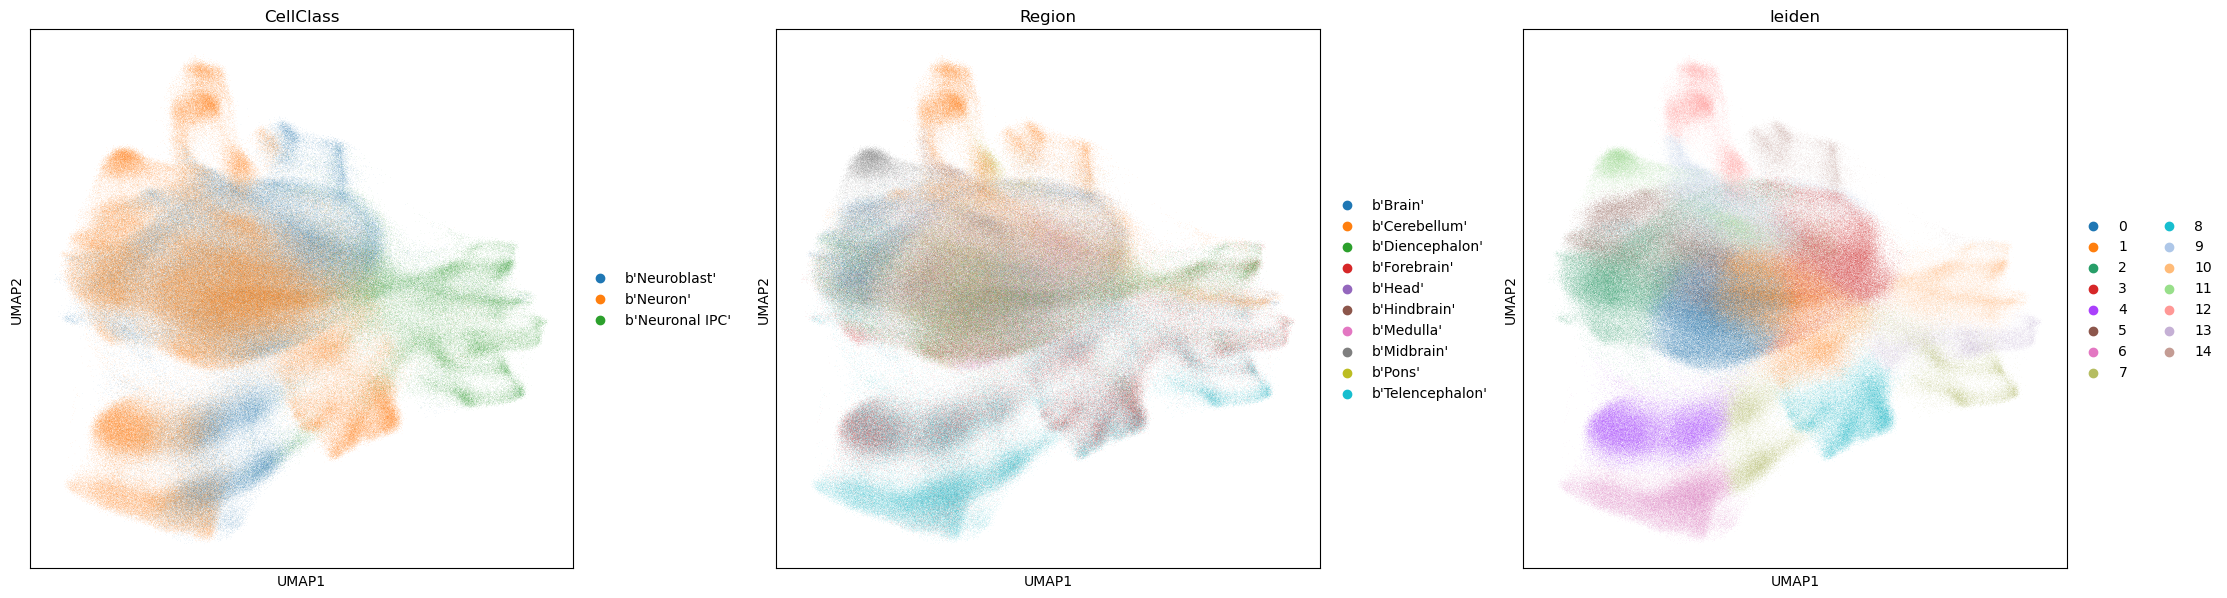

In [33]:
plt.rcParams['figure.figsize']=(7,7)
sc.pl.umap(ref_adata_neurons, color=["CellClass","Region","leiden"], wspace=0.25)

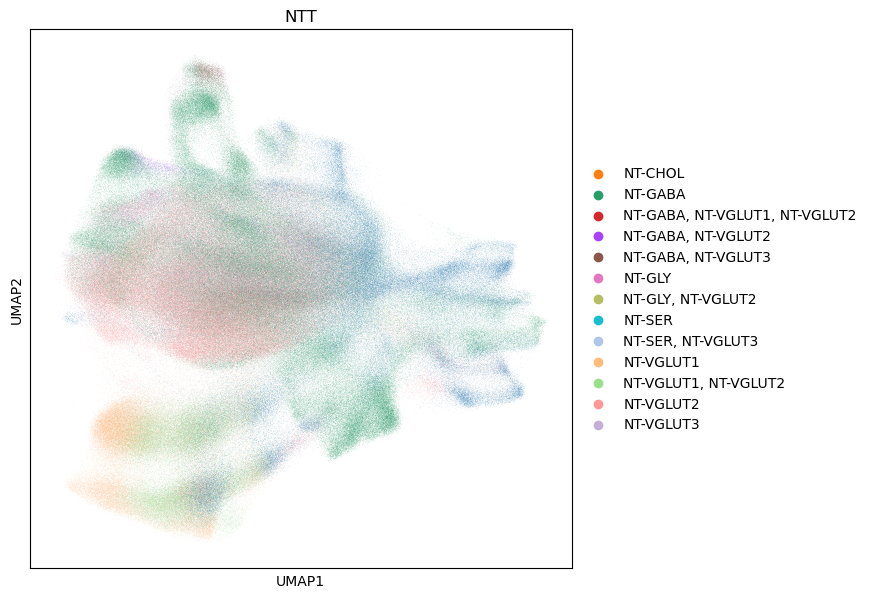

In [36]:
sc.pl.umap(ref_adata_neurons, color='NTT')

In [35]:
ref_adata_neurons.write_h5ad('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/braun_2024_fetal_brain_filtered_neuron_subset.h5ad')

In [66]:
ref_adata_neurons = sc.read_h5ad('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/braun_2024_fetal_brain_filtered_neuron_subset.h5ad')

## Create SCVI/SCANVI model

In [9]:
ref_adata_neurons.X = ref_adata_neurons.layers['counts'].copy()

In [7]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

scvi.settings.seed = 0

# PARAMS
BATCH_SIZE = 1024
EPOCHS_PRETRAIN = 500
EPOCHS_FINETUNE = 100

[rank: 0] Global seed set to 0


In [8]:
ref_adata_neurons.varm = dict()
ref_adata_neurons.obs["batch"] = ref_adata_neurons.obs["donor_id"].astype(str).copy()

In [9]:
scvi.model.SCVI.setup_anndata(
    ref_adata_neurons,
    batch_key="batch",
    )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [10]:
vae = scvi.model.SCVI(
    ref_adata_neurons,  
    n_latent=20,
    n_hidden=256,
    **arches_params,
    )

In [11]:
vae.train(
    batch_size=BATCH_SIZE,
    max_epochs=EPOCHS_PRETRAIN,
    early_stopping=True,
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-79a5ff83-cdbe-220c-cdc7-f33386b51572/0/0]


Epoch 422/500:  84%|████████▍ | 422/500 [1:55:17<21:18, 16.39s/it, loss=1.38e+03, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1375.191. Signaling Trainer to stop.


In [12]:
vae.save(
    os.path.join('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/models/scvi_neuron_ntt', "model.pt"),
    overwrite=True,
    save_anndata=False,
)

In [13]:
ref_adata_neurons.obs['NTT'] = ref_adata_neurons.obs['NTT'].astype(str)
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=ref_adata_neurons,
    labels_key='NTT',
    unlabeled_category="Unknown",
)

In [14]:
lvae.train(
    batch_size=BATCH_SIZE,
    max_epochs=EPOCHS_FINETUNE,
    n_samples_per_label=100,
    early_stopping=True,
)

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-79a5ff83-cdbe-220c-cdc7-f33386b51572/0/0]


Epoch 100/100: 100%|██████████| 100/100 [59:41<00:00, 37.04s/it, loss=1.45e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [59:41<00:00, 35.82s/it, loss=1.45e+03, v_num=1]


In [15]:
lvae.save(
    os.path.join('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/models/scanvi_neuron_NTT', "model.pt"),
    overwrite=True,
    save_anndata=False,
)

In [16]:
lvae.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.3.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'NTT',
│   'unlabeled_category': 'Unknown',
│   'layer': None,
│   'batch_key': 'batch',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   26   │
│         n_cells          │ 952786 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   15   │
│          n_vars          │  3000  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │ b'BRC2006'  │          0          │
│                    │ b'BRC2021'  │          1          │
│                    │ b'BRC2057'  │          2          │
│                    │ b'BRC2061'  │          3          │
│                    │ b'BRC2073'  │          4          │
│                    │ b'BRC2106A' │          5          │
│                    │ b'BRC2110'  │          6          │
│                    │ b'BRC2114'  │          7          │
│                    │ b'BRC2147'  │          8          │
│                    │ b'BRC2191'  │          9          │
│                    │ b'XDD:313'  │         10          │
│                    │ b'XDD:326'  │         11          │
│                    │ b'XDD:334'  │         12          │
│                    │ b'XDD:342'  │         13          │
│                    │ b'XDD:348'  │         14          │
│                    │ b'XDD:351'  │         15          │
│                    │ b'XDD:358'  │         16          │
│                    │ b'XDD:359'  │         17          │
│                    │ b'XDD:385'  │         18          │
│                    │ b'XDD:395'  │         19          │
│                    │ b'XDD:398'  │         20          │
│                    │ b'XDD:400'  │         21          │
│                    │ b'XHU:292'  │         22          │
│                    │ b'XHU:297'  │         23          │
│                    │ b'XHU:305'  │         24          │
│                    │ b'XHU:307'  │         25          │
└────────────────────┴─────────────┴─────────────────────┘

                          labels State Registry                           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Source Location  ┃          Categories           ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['NTT'] │                               │          0          │
│                  │            NT-CHOL            │          1          │
│                  │            NT-GABA            │          2          │
│                  │ NT-GABA, NT-VGLUT1, NT-VGLUT2 │          3          │
│                  │      NT-GABA, NT-VGLUT2       │          4          │
│                  │      NT-GABA, NT-VGLUT3       │          5          │
│                  │            NT-GLY             │          6          │
│                  │       NT-GLY, NT-VGLUT2       │          7          │
│                  │            NT-SER             │          8          │
│                  │       NT-SER, NT-VGLUT3       │          9          │
│                  │           NT-VGLUT1           │         10          │
│                  │     NT-VGLUT1, NT-VGLUT2      │         11          │
│                  │           NT-VGLUT2           │         12          │
│                  │           NT-VGLUT3           │         13          │
│                  │            Unknown            │         14          │
└──────────────────┴───────────────────────────────┴─────────────────────┘

In [ ]:
lvae = scvi.model.SCANVI.load('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/models/scanvi_neuron_region/model.pt')

INFO     File                                                                                                      
         /hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/models/scanvi_glia_re
         gion/model.pt/model.pt already downloaded                                                                 


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scvi/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


# Subset our data and process neurons

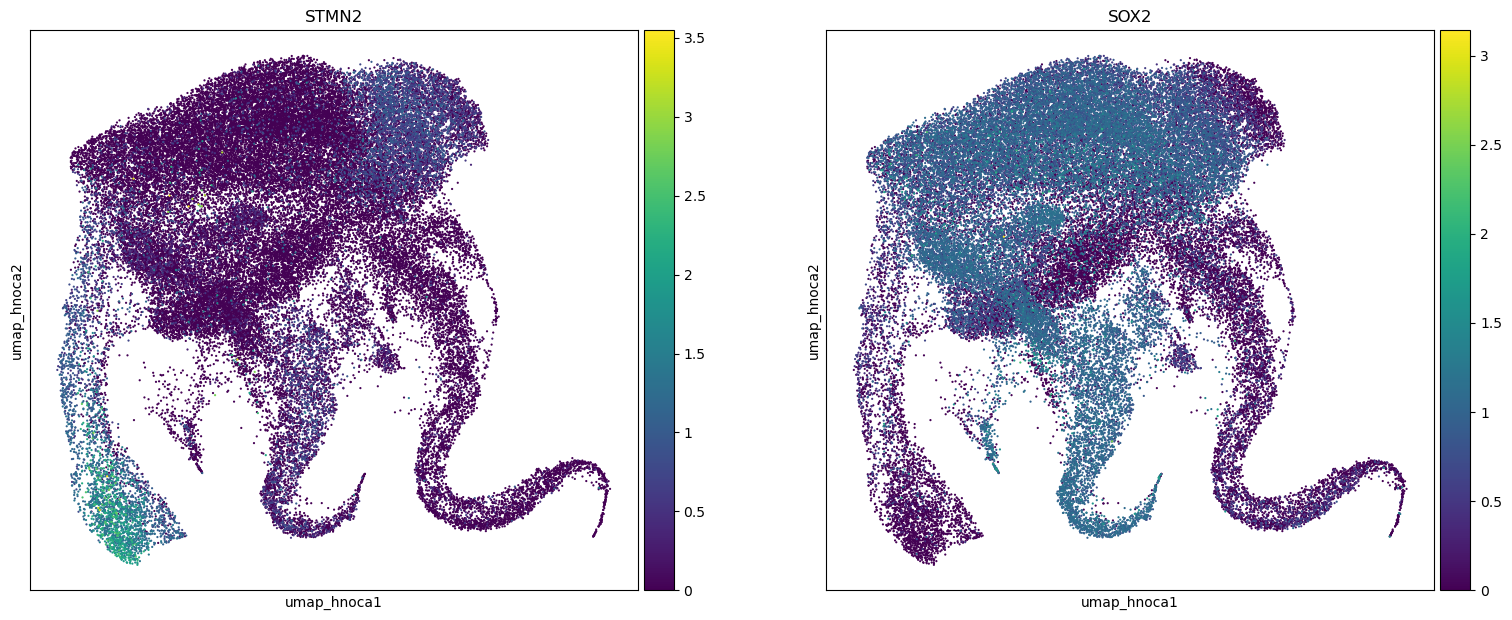

In [17]:
plt.rcParams['figure.figsize']=(7,7)
sc.pl.scatter(adata, basis='umap_hnoca', color=['STMN2',"SOX2"], size=10)

In [12]:
neurons = ['Medulla Neuron','Hypothalamic Neuron']
neuron_adata = adata[adata.obs["hnoca_leiden_level_3"].isin(neurons)].copy()
neuron_adata

AnnData object with n_obs × n_vars = 3617 × 23409
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'singlets', 'Day', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'leiden_res_1', 'leiden_res_2', 'leiden_res_3', 'leiden_res_4', 'S_score', 'G2M_score', 'phase', 'leiden_diffmap_res_4', 'snapseed_level_1', 'snapseed_level_2', 'snapseed_level_3', 'snapseed_level_4', 'snapseed_level_5', 'leiden_res_0.5', 'hnoca_level_1', 'hnoca_level_1_score', 'hnoca_level_1_logscore', 'hnoca_level_2', 'hnoca_level_2_score', 'hnoca_level_2_logscore', 'hnoca_level_3', 'hnoca_level_3_score', 'hnoca_level_3_logscore', 'hnoca_level_4', 'hnoca_level_4_score', 'hnoca_level_4_logscore', 'hdbca_

In [14]:
neuron_adata = neuron_adata[~neuron_adata.obs['Day'].isin(["005","011","014"])]

### Now we can reference map it against our previously trained SCANVI model

In [27]:
adata.obs["batch"] = adata.obs["Day"].astype('category')

In [28]:
adata.obs["CellClass"] = "Unknown"
adata.obs["Region"] = "Unknown"
adata.obs["Subregion"] = "Unknown"
adata.obs["Age"] = "=Unknown"

In [29]:
del adata.varm

In [30]:
adata.X = adata.layers['counts'].copy()

In [31]:
scvi.model.SCANVI.prepare_query_anndata(adata, lvae)

INFO     Found 100.0% reference vars in query data.                                                                


In [32]:
vae_q = scvi.model.SCANVI.load_query_data(adata, lvae)

In [34]:
vae_q.train(
    batch_size=1024,
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-79a5ff83-cdbe-220c-cdc7-f33386b51572/0/0]


Epoch 100/100: 100%|██████████| 100/100 [00:13<00:00,  7.46it/s, loss=1.42e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [00:13<00:00,  7.21it/s, loss=1.42e+03, v_num=1]


In [35]:
query_emb = anndata.AnnData(vae_q.get_latent_representation())
query_emb.obs_names = adata.obs_names

In [36]:
ref_emb = anndata.AnnData(vae_q.get_latent_representation(ref_adata_neurons))

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [37]:
combined_emb = sc.concat(
    (ref_emb, query_emb), index_unique=None, join="outer"
) 

In [47]:
transfers = ["CellClass","Region","Subregion",'NTT']

In [39]:
ref_adata_neurons.obsm['SCANVI'] = vae_q.get_latent_representation(ref_adata_neurons)

In [40]:
X_train = ref_adata_neurons.obsm['SCANVI']
ref_nn_index = pynndescent.NNDescent(X_train)
ref_nn_index.prepare()

In [48]:
ref_adata_neurons.obs[transfers] = ref_adata_neurons.obs[transfers].astype('category')

In [58]:
ref_neighbors, ref_distances = ref_nn_index.query(query_emb.X)

# convert distances to affinities
stds = np.std(ref_distances, axis=1)
stds = (2.0 / stds) ** 2
stds = stds.reshape(-1, 1)
ref_distances_tilda = np.exp(-np.true_divide(ref_distances, stds))
weights = ref_distances_tilda / np.sum(ref_distances_tilda, axis=1, keepdims=True)


@numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty


# for each annotation level, get prediction and uncertainty
label_keys = transfers
for l in label_keys:
    ref_cats = ref_adata_neurons.obs[l].cat.codes.to_numpy()[ref_neighbors]
    p, u = weighted_prediction(weights, ref_cats)
    p = np.asarray(ref_adata_neurons.obs[l].cat.categories)[p]
    query_emb.obs[l + "_pred"], query_emb.obs[l + "_uncertainty"] = p, u

In [50]:
uncertainty_threshold = 0.4
for l in label_keys:
    mask = query_emb.obs[l + "_uncertainty"] > uncertainty_threshold
    print(f"{l}: {sum(mask)/len(mask)} unknown")
    query_emb.obs[l + "_pred_unfiltered"] = query_emb.obs[l + "_pred"].copy()
    query_emb.obs[l + "_pred"].loc[mask] = "Unknown"

CellClass: 0.21259403733630539 unknown
Region: 0.796600724435776 unknown
Subregion: 0.8854834215658958 unknown
NTT: 0.4321538032878239 unknown


In [59]:
for t in transfers:
    print(t)
    adata.obs[f'{t}_pred'] = query_emb.obs[f'{t}_pred']
    adata.obs[f'{t}_pred_unfiltered'] = query_emb.obs[f'{t}_pred_unfiltered']
    adata.obs[f'{t}_uncertainty'] = query_emb.obs[f'{t}_uncertainty']

CellClass
Region
Subregion
NTT


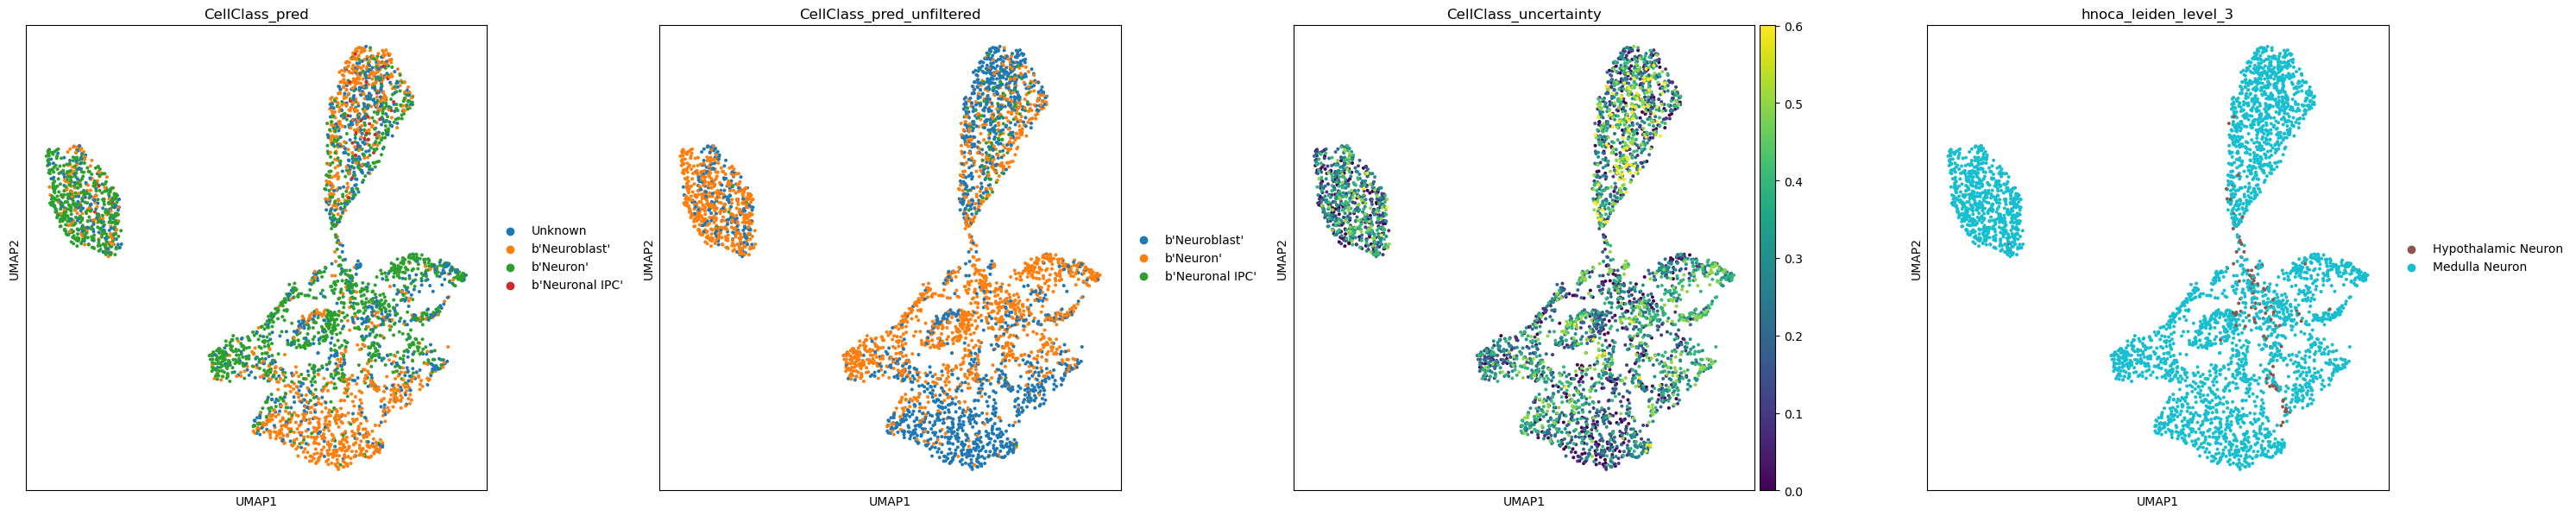

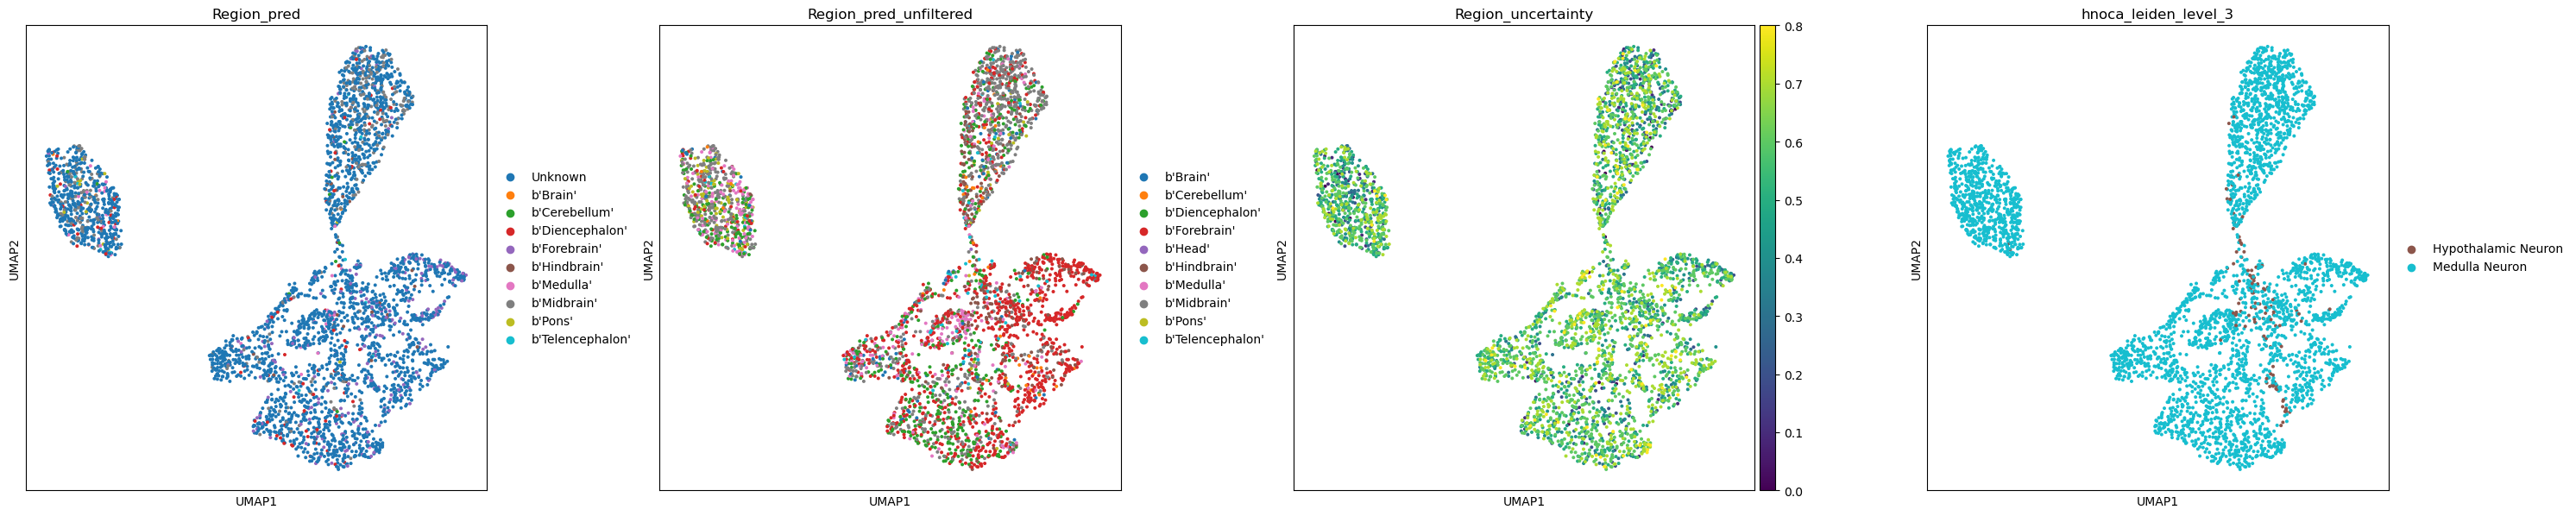

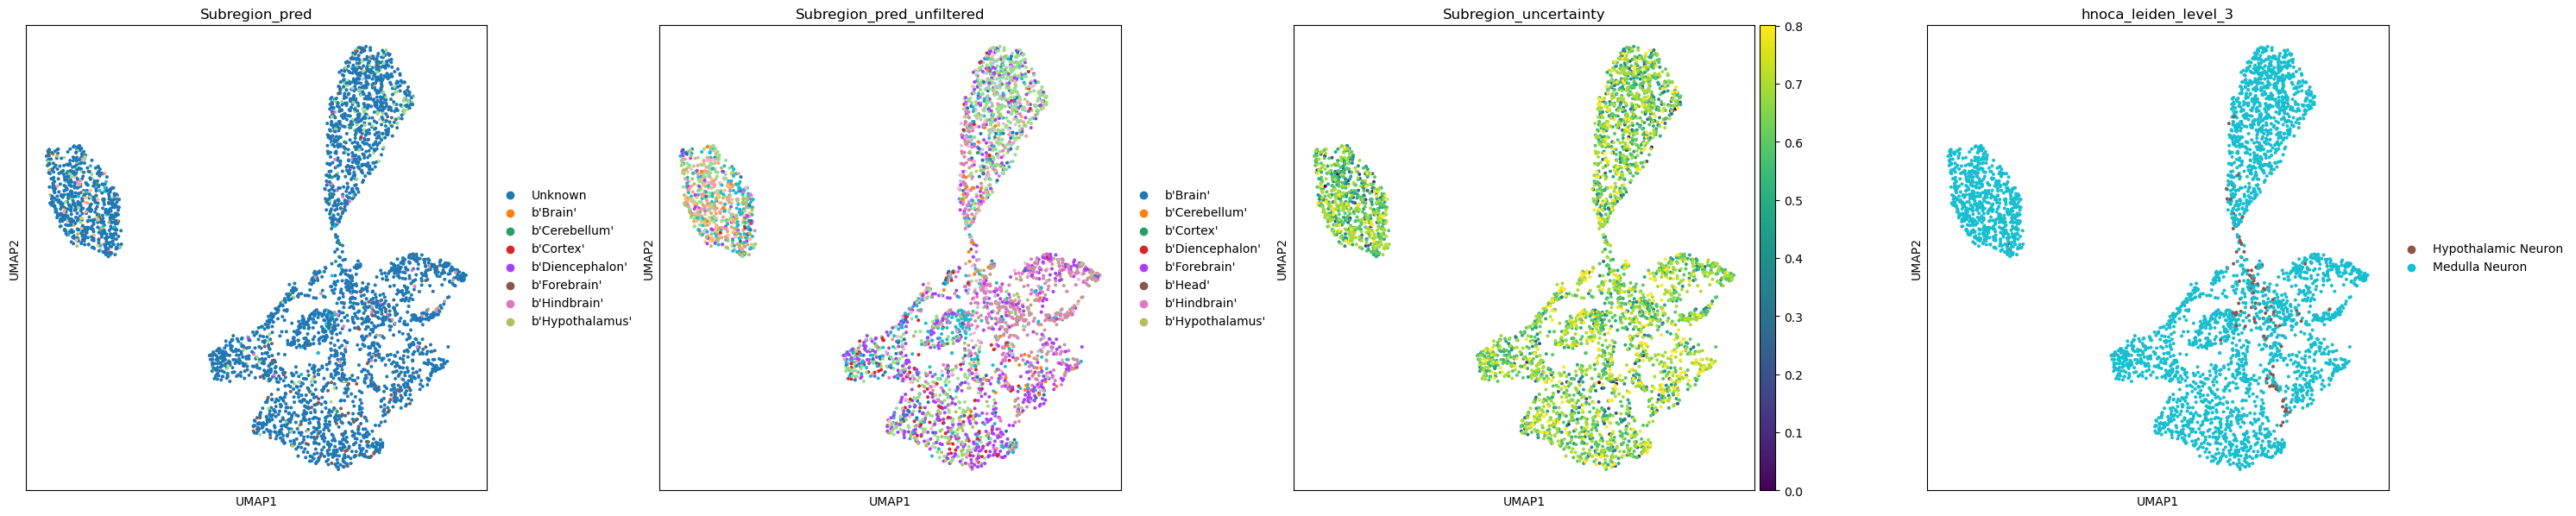

In [47]:
for t in transfers:
    sc.pl.umap(adata, color=[f'{t}_pred',f'{t}_pred_unfiltered',f'{t}_uncertainty','hnoca_leiden_level_3'], wspace=0.25)

In [62]:
del adata.uns['NTT_pred_colors']

In [ ]:
region_dict = {
    "b'Forebrain'" : "Forebrain",
    "b'Midbrain'" : "Midbrain",
    "b'Telencephalon'" : "Forebrain",
    "b'Diencephalon'" : "Forebrain",
    "b'Pons'" : "Hindbrain",
    "b'Medulla'" : "Medulla",
    "b'Hindbrain'" : "Hindbrain",
    "Unknown" : "Unknown",
}

adata.obs["region_broad"] = adata.obs['Region_pred'].map(region_dict).astype("category")

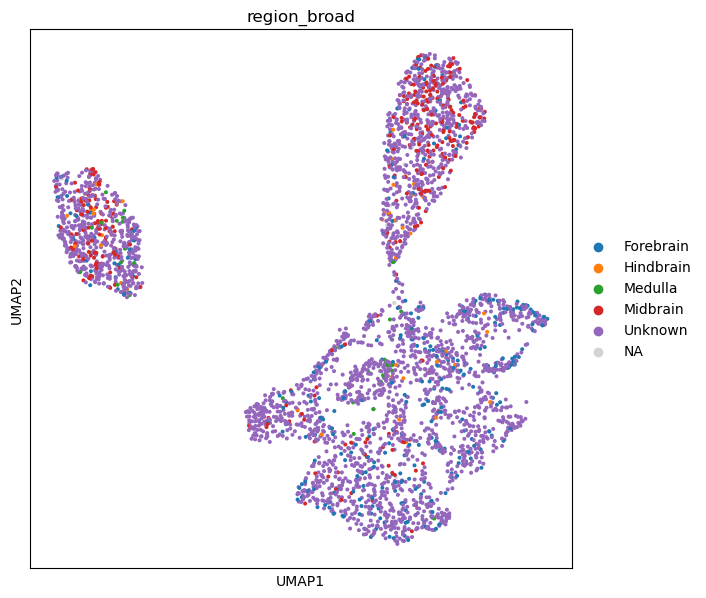

In [ ]:
sc.pl.umap(adata, color="region_broad")